###Dependencies

In [ ]:
!pip install -U transformers bitsandbytes accelerate --q
!pip install python-Levenshtein --q
!pip install pillow-avif-plugin --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import requests
from PIL import Image
from pathlib import Path
import urllib
from imageio import imread
import requests
from io import BytesIO
import glob
import torch
from transformers import AutoProcessor, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, MllamaForConditionalGeneration, PaliGemmaForConditionalGeneration, AutoModelForZeroShotImageClassification
from unittest.mock import patch
from transformers import pipeline
from transformers.dynamic_module_utils import get_imports
from PIL import Image, ImageDraw, ImageFont
from itertools import cycle
import numpy as np
import pandas as pd
import os
import getpass
from tqdm import tqdm
from Levenshtein import ratio, distance
from itertools import combinations
import torch
from tqdm import tqdm

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

###LLama Model

In [ ]:
class LLaMAModel:
    def __init__(self, model_id="meta-llama/Llama-3.2-11B-Vision-Instruct"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model_id = model_id
        self.model = MllamaForConditionalGeneration.from_pretrained(
            model_id,
            quantization_config=quantization_config,
            # torch_dtype=torch.bfloat16,
            device_map="auto",
        ).eval()
        self.processor = AutoProcessor.from_pretrained(model_id)

    def run_example(self, task_prompt: str, image: Image, **kwargs):
        messages = [
            {"role": "user", "content": [
                {"type": "image"},
                {"type": "text", "text": task_prompt}
            ]}
        ]
        input_text = self.processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = self.processor(
            image,
            input_text,
            add_special_tokens=False,
            return_tensors="pt"
        ).to(self.model.device, self.model.dtype)

        output = self.model.generate(**inputs, max_new_tokens=25, **kwargs)
        generated_text = self.processor.decode(output[0], skip_special_tokens=True)
        logo_name = generated_text.strip().split('assistant')[-1].strip().strip('.')
        return logo_name

    def run_examples(self, prompts, image, repetitions=1, **kwargs):
        results = [{'prompt': prompt,
                    'answer': self.run_example(prompt, image, **kwargs)}
                   for prompt in prompts for _ in range(repetitions)]
        results_df = pd.DataFrame(results)
        results_df['yes'] = results_df['answer'].str.lower().str.contains('yes')
        results_df['no'] = results_df['answer'].str.lower().str.contains('no')
        results_df['include'] = (results_df['yes'] | results_df['no'])
        return results_df

    def get_logo_name(self, image: Image):
        prompt = "Detect the logo in the clothing. What is the full brand name of this logo? Only give the brand name (no special characters or extra words)"
        return self.run_example(prompt, image=image)

In [ ]:
os.environ["HF_TOKEN"] = getpass.getpass()

··········


In [ ]:
llama_model = LLaMAModel()

config.json:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

###Image testing

In [ ]:
# image_1 = Image.open(phase1_path/"output/17_69.png")
from google.colab import files
import pillow_avif
from PIL import Image
# Prompt to upload your image file(s) from your local machine
uploaded = files.upload()

# Assuming one image is uploaded, get its filename
file_name = list(uploaded.keys())[0]

# Open the uploaded image
img = Image.open(file_name)

Saving eCom-824404TSVB31300_G.avif to eCom-824404TSVB31300_G.avif


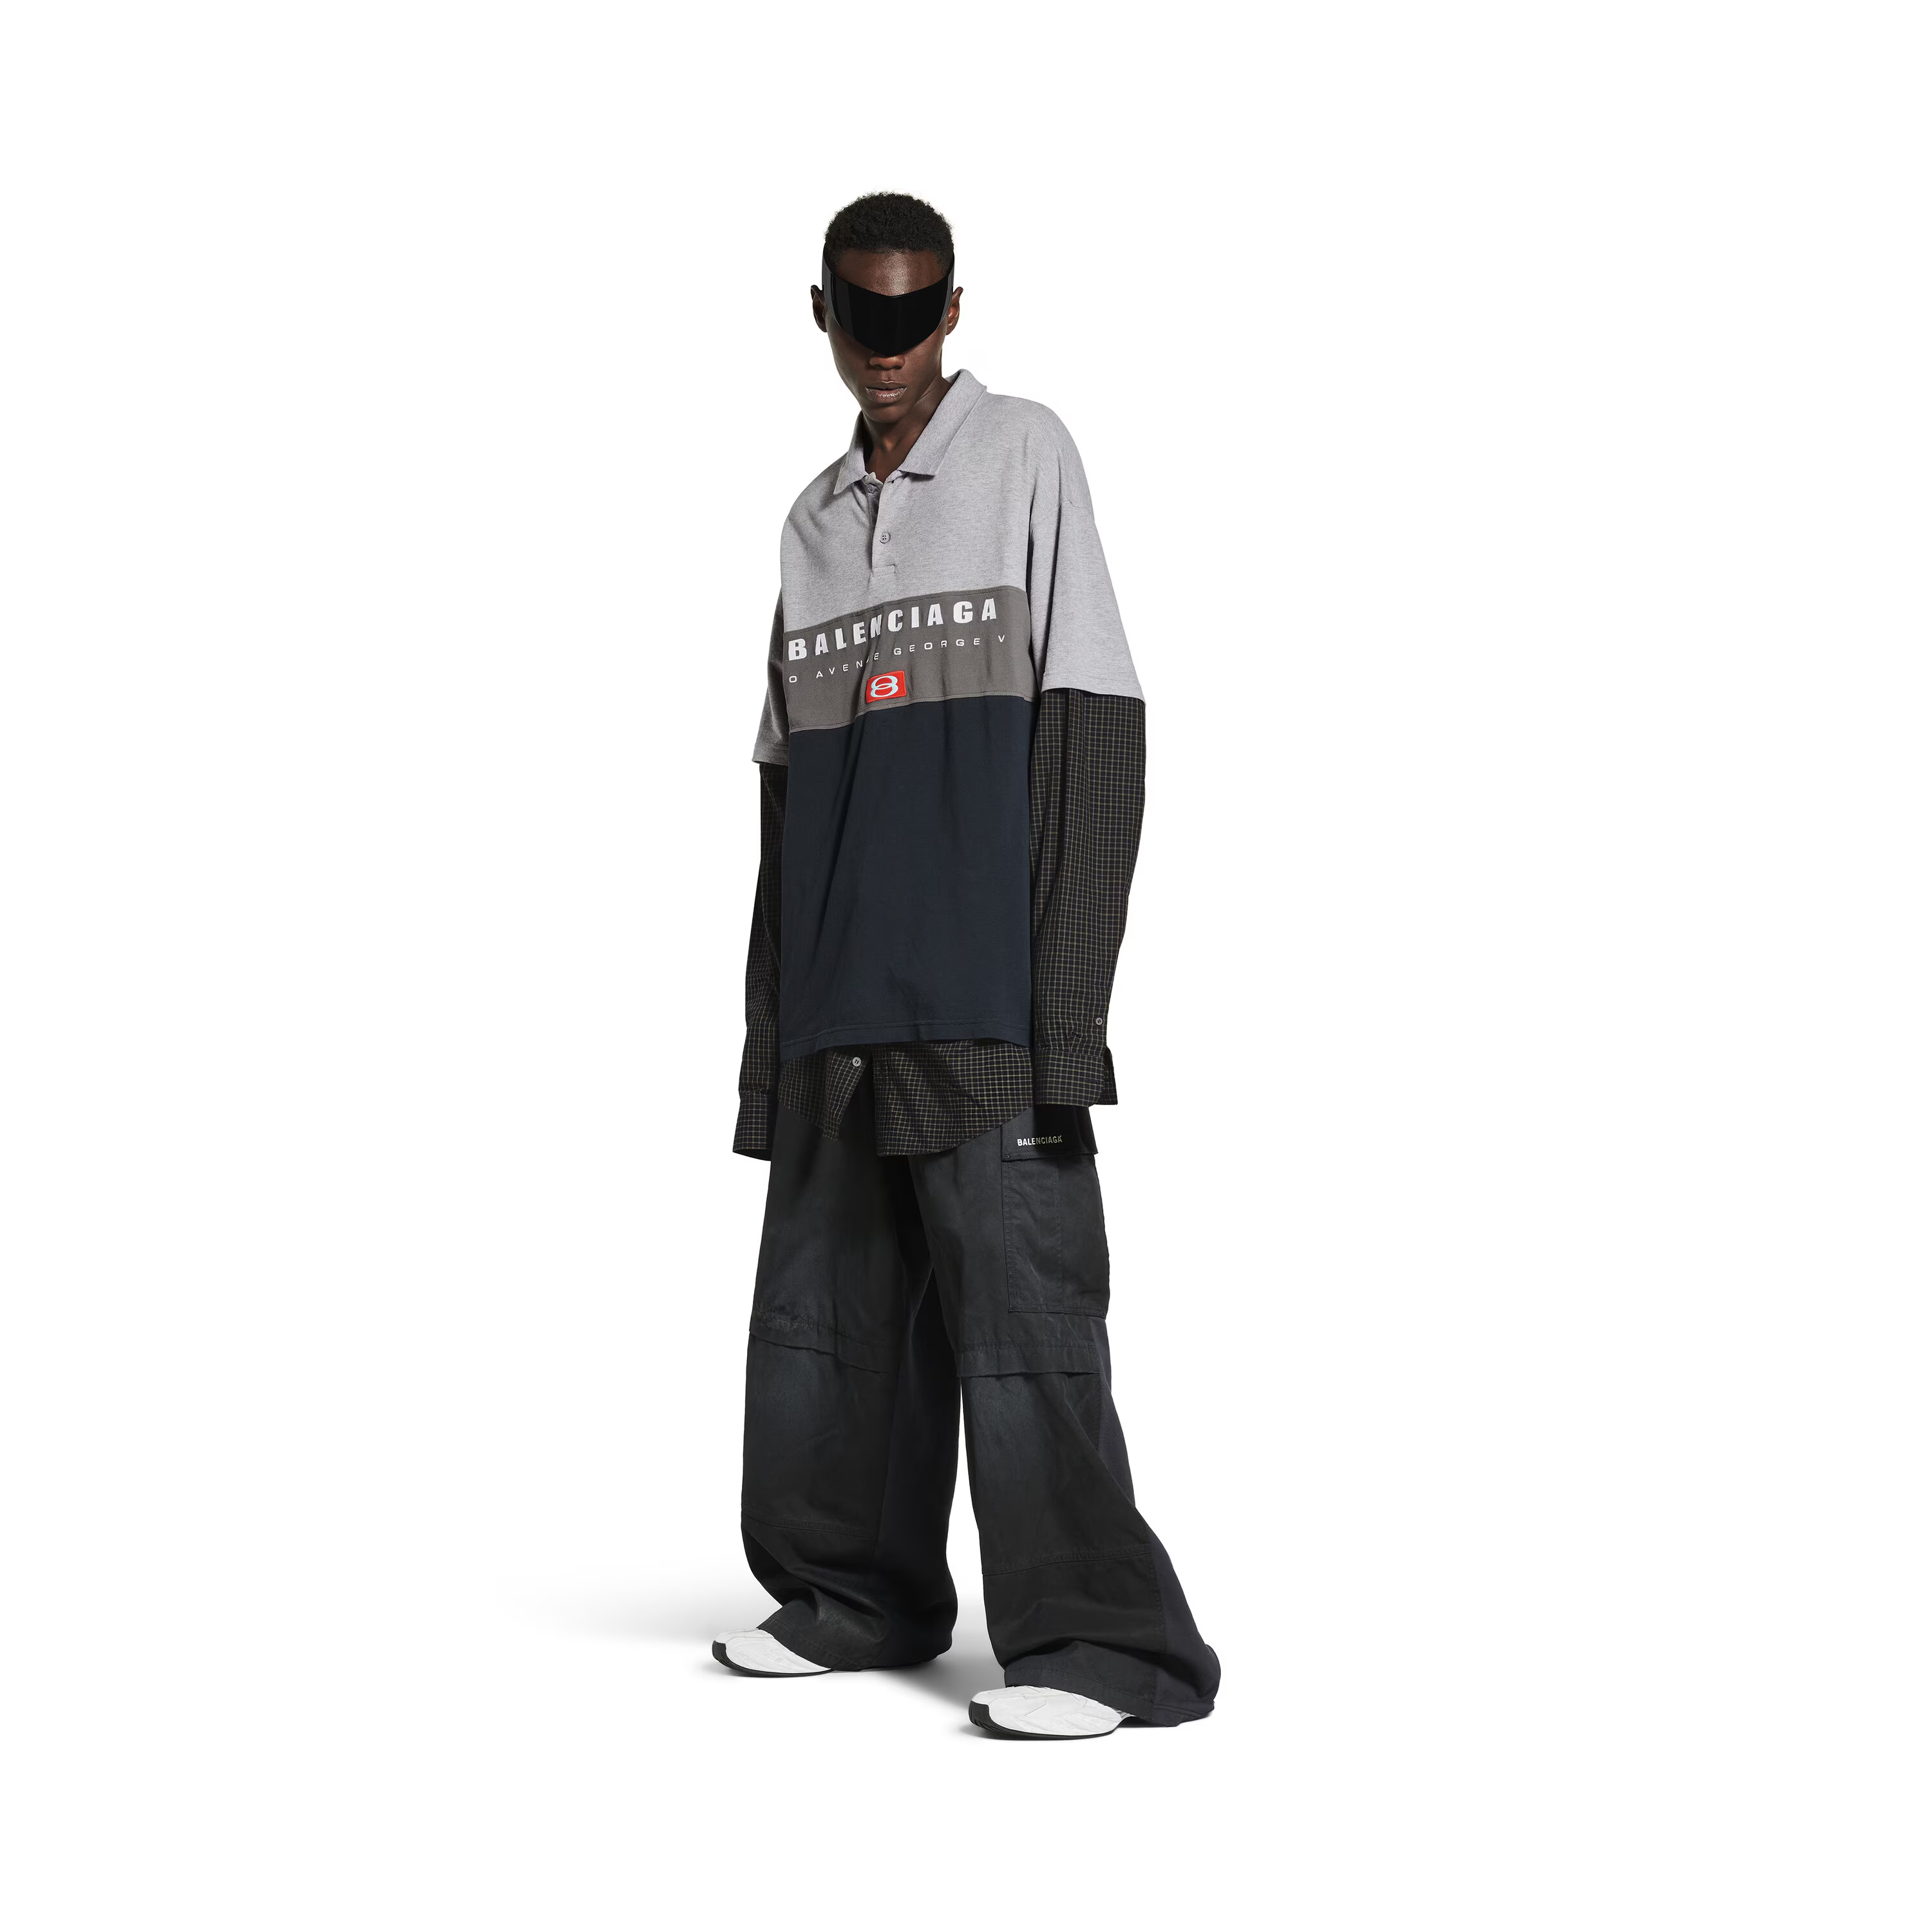

In [ ]:
img

####Garments And Colors

In [ ]:
llama_model.run_example(
    "Analyze the image and list every garment worn by the model, along with its predominant color(s)."
    "Return response in json format"
    # "{Garment type: Color(s), }"
    "Example format: {shirt: white , jeans: grey,..}"
    "Strictly dont return any other information other than format defined! Give the response like example defined",
    img,
)

'{shirt: grey, black, white, grey, black, black, grey, black, black, grey, black,'

####Brand/ Designer

In [ ]:
# # Define the allowed fashion designers
# allowed_brands = ["Louis Vuitton", "Prada", "Hermès", "Balenciaga", "Dior", "Saint Laurent",
#                   "Fendi", "Burberry", "Versace", "Givenchy", "Valentino", "Dolce & Gabbana", "Armani",
#                   "Bottega Veneta", "Alexander McQueen", "Celine", "Loewe", "Off-White", "Supreme", "Off-White",
#                   "A Bathing Ape (BAPE)", "Palace", "Fear of God", "Kith", "Noah", "Vetements",
#                   "Yeezy (formerly by Kanye West)", "Billionaire Boys Club", "Ambush", "A-Cold-Wall",
#                   "Heron Preston", "Carhartt WIP", "Stone Island", "Comme des Garçons", "Undercover", "WTAPS",
#                   "Neighborhood", "Nike", "Adidas", "Puma", "Under Armour", "Lululemon", "Stüssy", "Reebok", "Fila", "New Balance",
#                   "ASICS", "The North Face", "Patagonia", "Columbia Sportswear", "Champion", "Athleta", "Gymshark",
#                   "Sweaty Betty", "Outdoor Voices", "Salomon", "Arc'teryx", "On Running", "Zara", "H&M", "Uniqlo",
#                   "Forever 21", "Gap", "Old Navy", "Gucci", "Primark", "Topshop", "ASOS", "Boohoo", "Shein", "Fashion Nova",
#                   "Mango", "Pull & Bear", "Bershka", "Urban Outfitters", "American Eagle", "Hollister", "Chanel",
#                   "Abercrombie & Fitch", "Cotton On", "Levi’s", "Wrangler", "Diesel", "Lee", "Guess", "Tommy Hilfiger",
#                   "Calvin Klein", "Ralph Lauren", "G-Star Raw", "True Religion", "7 For All Mankind", "Lucky Brand", "AG Jeans",
#                   "Citizens of Humanity", "Hudson Jeans", "Joe’s Jeans", "Paige Denim", "Nudie Jeans", "Edwin", "Re/Done"]

# # Create a comma-separated string of allowed patterns
# brands_str = ", ".join(allowed_brands)

# # Construct the query so that only the specified patterns are considered
# # query = (
# #     f"Tell me the fashion Fashion brand/designer/logo on the outfit from the following list: {allowed_brands}. "
# #     "If you cant identify then search for any letters or writing anywhere on the outfit"
# #     "Look at the collar and then return the text"
# #     "Just return the text No extra information is needed from your side"
# # )

# # Construct the query so that only the specified patterns are considered
# query = (
#     f"Analyze the image and identify the fashion brands/logos/designers on the outfit from the following list: {allowed_brands}. "
#     "List only the garments worn by the model having fashion brands/logos/designers. Strictly dont mention plain garments!"
#     "Return response in json format like the following example:"
#     # "{Garment type: brand(s), }"
#     "{Jacket: Gucci, shirt: None, jeans: prada..}"
#     "If you cant identify the brand name on any garment, then only return 'No brand' in json format."
#     "No extra information or comments needed besides the json format"
# )


# # Run the model with the modified query
# result_brand = llama_model.run_example(query, img)

# print(result_brand)

In [ ]:
# import random

# allowed_brands = random.shuffle(allowed_brands)
# print(allowed_brands)

None


In [ ]:
# allowed_brands = random.shuffle(allowed_brands)
#Here is how you can run ONE single prompt on the image using the run_example function
query = (
    f"Analyze the image and tell me the Fashion logo/brand/designer/ on the garment "
    # f"Identify the fashion pattern on the outfit from the following list: {allowed_brands}. from the following list: {allowed_brands}""
    "Return response in json format"
    # "{Garment type: Pattern, }"
    "Example format: {Designer: Gucci, Pradda..}"
    "Return {Designer: None} if you cant find any brand on any garment"
    "Strictly dont return any other information other than the defined format! Only return a JSON format as described"
)

llama_model.run_example(query,img)

'{Designer: Burberry}'

In [ ]:
#Here is how you can run ONE single prompt on the image using the run_example function
llama_model.run_example("Tell me the Fashion brand/designer/logo on the outfit. Just return the name. No extra information",
                        img)

'Balenciaga'

####Patterns

In [ ]:
# Define the allowed fashion patterns
allowed_patterns = [
    "Houndstooth", "Herringbone", "Chevron", "Paisley", "Plaid (Tartan)", "Gingham", "Argyle",
    "Polka Dots", "Stripes (Vertical, Horizontal, Diagonal)", "Pin Stripes", "Windowpane", "Tattersall",
    "Buffalo Check", "Madras","Seersucker","Moroccan Tile Patterns","Greek Key","Zigzag",
    "Diamond Patterns","Kaleidoscope Patterns","Leopard Print","Zebra Print","Tiger Print","Snake Print",
    "Giraffe Print","Cheetah Print","Aztec Patterns","Graffiti Prints","Cubist Patterns","Camouflage"
]

# Create a comma-separated string of allowed patterns
patterns_str = ", ".join(allowed_patterns)

# Construct the query so that only the specified patterns are considered
query = (
    "Analyze the image and ONLY list garments worn by the model having fashion pattern."
    f"Identify the fashion pattern on the outfit from the following list: {patterns_str}. "
    "Return response in json format."
    # "{Garment type: Pattern, }"
    "Example format: {shirt: Chevron, skirt: plaid,..}"
    "Return {pattern: None} if you cant find any pattern"
    "Strictly dont return any other information other than format defined! Give the response like example defined",
)

# Run the model with the modified query
result_pattern = llama_model.run_example(query, img)

print(result_pattern)

{pattern: None}
